In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint

import lmfit

from tqdm import tqdm
tqdm.pandas()

from pathlib import Path
from utils import *
from plots import *
from sird import *

In [2]:
data_path = "data"

In [3]:
DataDownloader().download_all_csv()

In [4]:
covidpro_df = pd.read_csv(Path(data_path, CSVName.COVIDPRO_CSV))
dpc_regioni_df = pd.read_csv(Path(data_path, CSVName.DPC_REGIONI))
dpc_province_df = pd.read_csv(Path(data_path, CSVName.DPC_PROVINCE))
pop_prov_df = pd.read_csv(Path(data_path, CSVName.POP_PROV_CSV))

In [5]:
dpc_province_df['data'] = pd.to_datetime(dpc_province_df['data'])
dpc_regioni_df['data'] = pd.to_datetime(dpc_regioni_df['data'])
covidpro_df['Date'] = pd.to_datetime(covidpro_df['Date'])

In [6]:
dpc_province_df.denominazione_provincia = \
    dpc_province_df.denominazione_provincia.str \
        .replace("Forlì-Cesena", "Forli-Cesena")

dpc_regioni_df.denominazione_regione = \
    dpc_regioni_df.denominazione_regione.str \
        .replace("P.A. Trento", "Trentino Alto Adige") \
        .replace("P.A. Bolzano", "Trentino Alto Adige")

covidpro_df.Region = covidpro_df.Region.str \
                        .replace("P.A. Trento", "Trentino Alto Adige") \
                        .replace("P.A. Bolzano", "Trentino Alto Adige")

pop_prov_df.Territorio = pop_prov_df.Territorio.str \
                            .replace("Valle d'Aosta", "Aosta") \
                            .replace("Forlì-Cesena", "Forli-Cesena") \
                            .replace("Massa-Carrara", "Massa Carrara") \
                            .replace("L'Aquila", "L Aquila") \
                            .replace("Reggio nell'Emilia", 'Reggio nell Emilia')

In [7]:
province = 'Firenze'

sirsol = sird(province, pop_prov_df)
S, I, R, D = sirsol

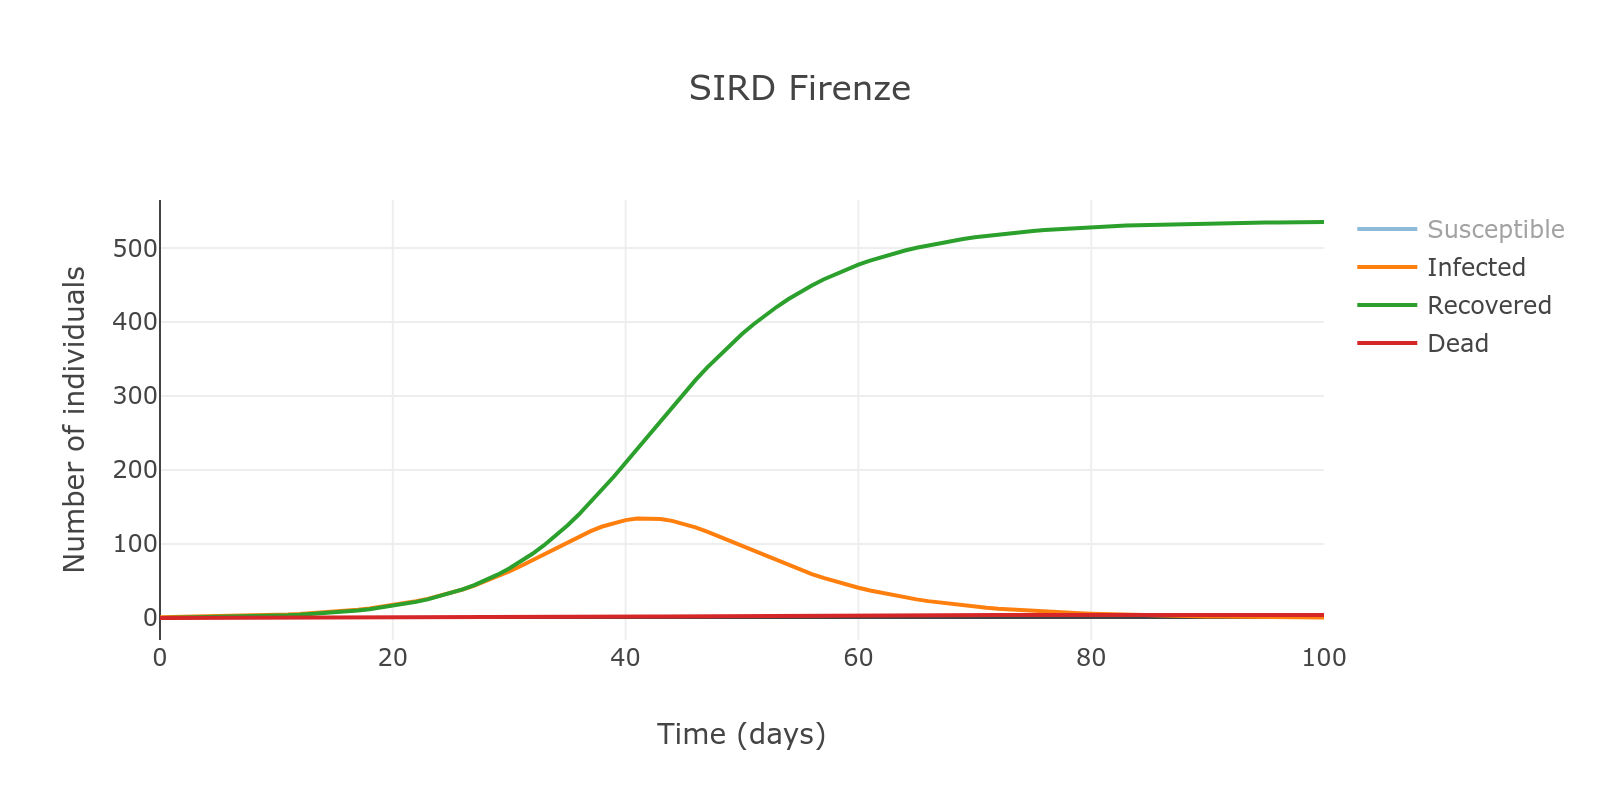

In [8]:
times = list(range(sirsol.shape[1]))

general_plot(t=times, 
             data=sirsol, 
             title=province,
             traces_visibility=['legendonly'] + [True]*3,
             output_image=True)

In [ ]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    S, I, R, D = sird(prov, pop_prov_df)
    tmp = pd.DataFrame(np.column_stack([[prov]*len(S),range(len(S)),S,I,R,D]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "S", "I", "R", "D"]
result.reset_index(drop=True,inplace=True)

In [ ]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Firenze', 
                    dropdown_label='Province',
                    y=["S", "I", "R", "D"],
                    legend_titles=['Susceptible', 'Infected', 'Recovered', 'Dead'],
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 trendlines of ',
                    xtitle='Data',
                    ytitle='Unità',
                    output_image=False)

In [9]:
mapping = {
    'New_cases': 2,
    'Curr_pos_cases': 2,
    'Tot_deaths': 4,
    'Deaths': ('Deaths', D),
    'Infected': ('New_cases', I)
}

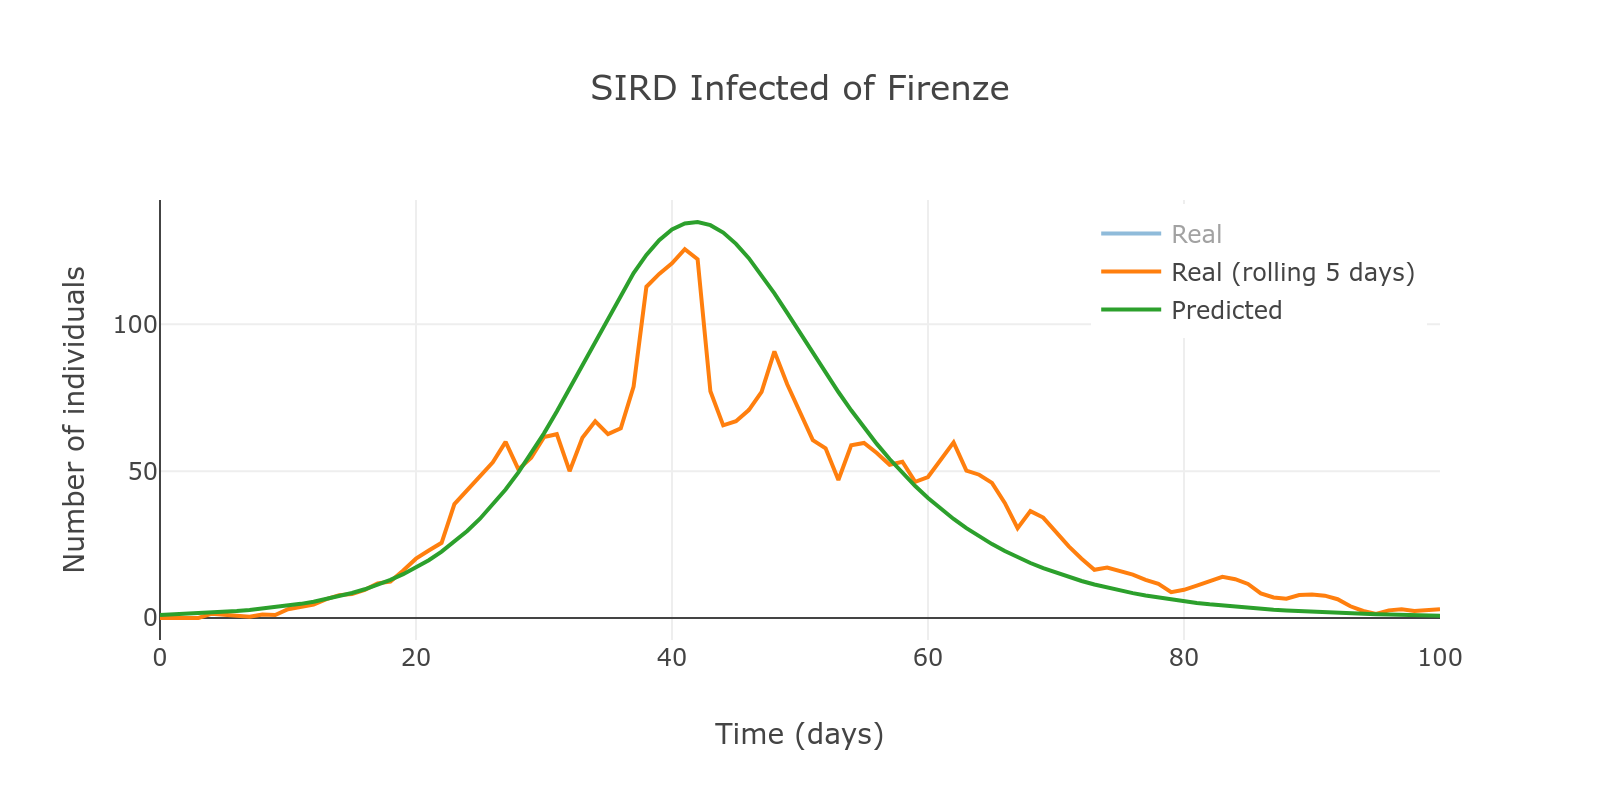

In [10]:
names, title, data, modes = data_for_plot('Infected', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data,
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

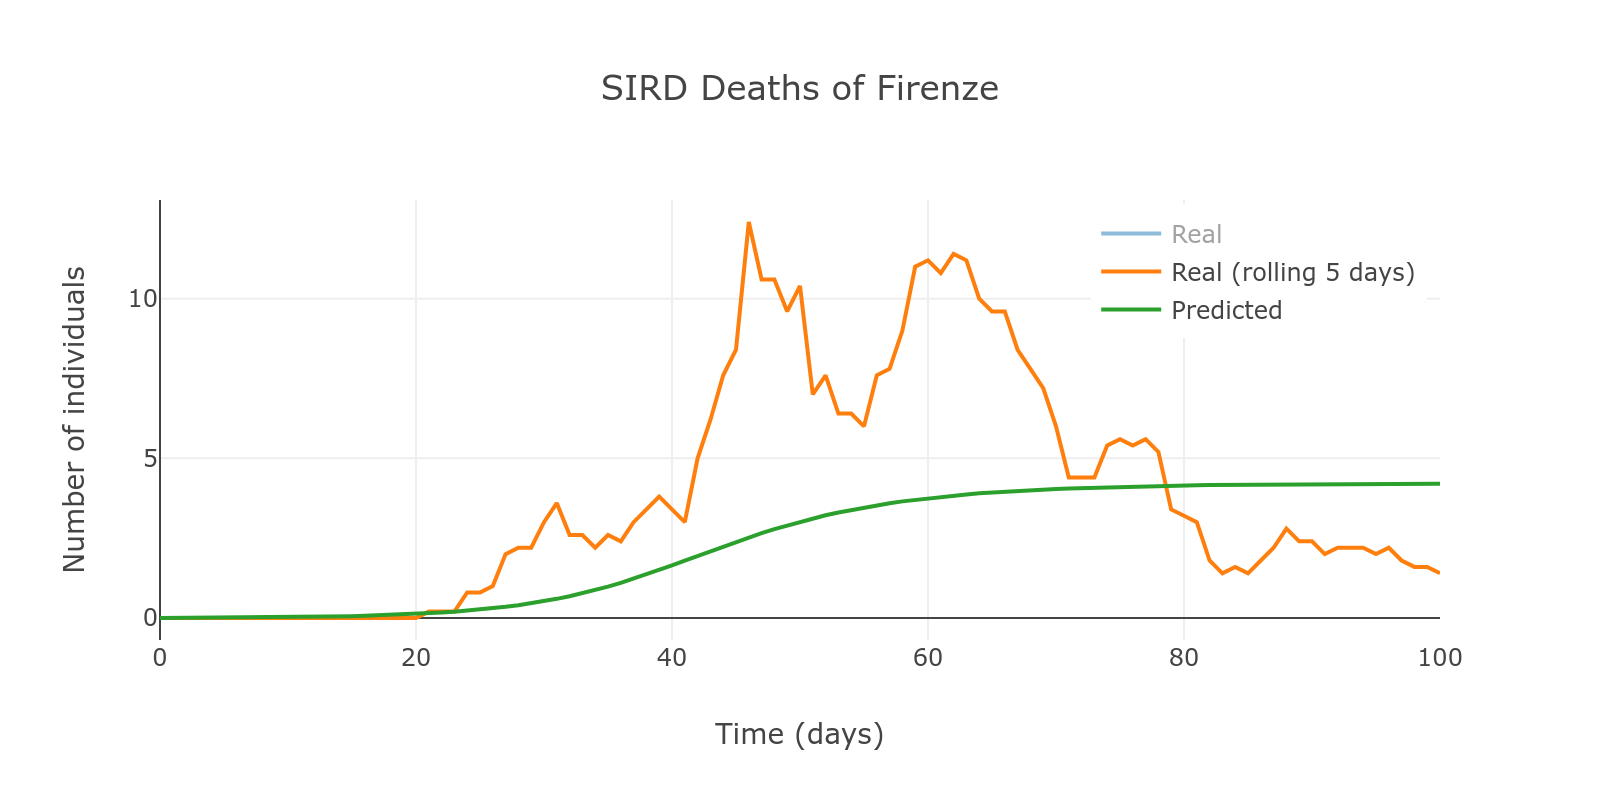

In [11]:
names, title, data, modes = data_for_plot('Deaths', covidpro_df, mapping, province)

general_plot(t=times,
             title=title,
             data=data, 
             names=names,
             modes=modes,
             blend_legend=True,
             output_image=True,
             traces_visibility=['legendonly',True,True])

In [12]:
result = pd.DataFrame()
for prov in covidpro_df.Province.unique():
    _, I, _, _ = sird(prov, pop_prov_df)
    names, _, data, _ = data_for_plot('Infected', covidpro_df, mapping, prov)
    tmp = pd.DataFrame(np.column_stack([[prov]*data[2].shape[0],range(data[2].shape[0]),data[0],data[1],data[2]]))
    result = pd.concat([result, tmp])
    
result.columns = ["Province", "t", "real", "real_roll", "pred"]
result.reset_index(drop=True,inplace=True)

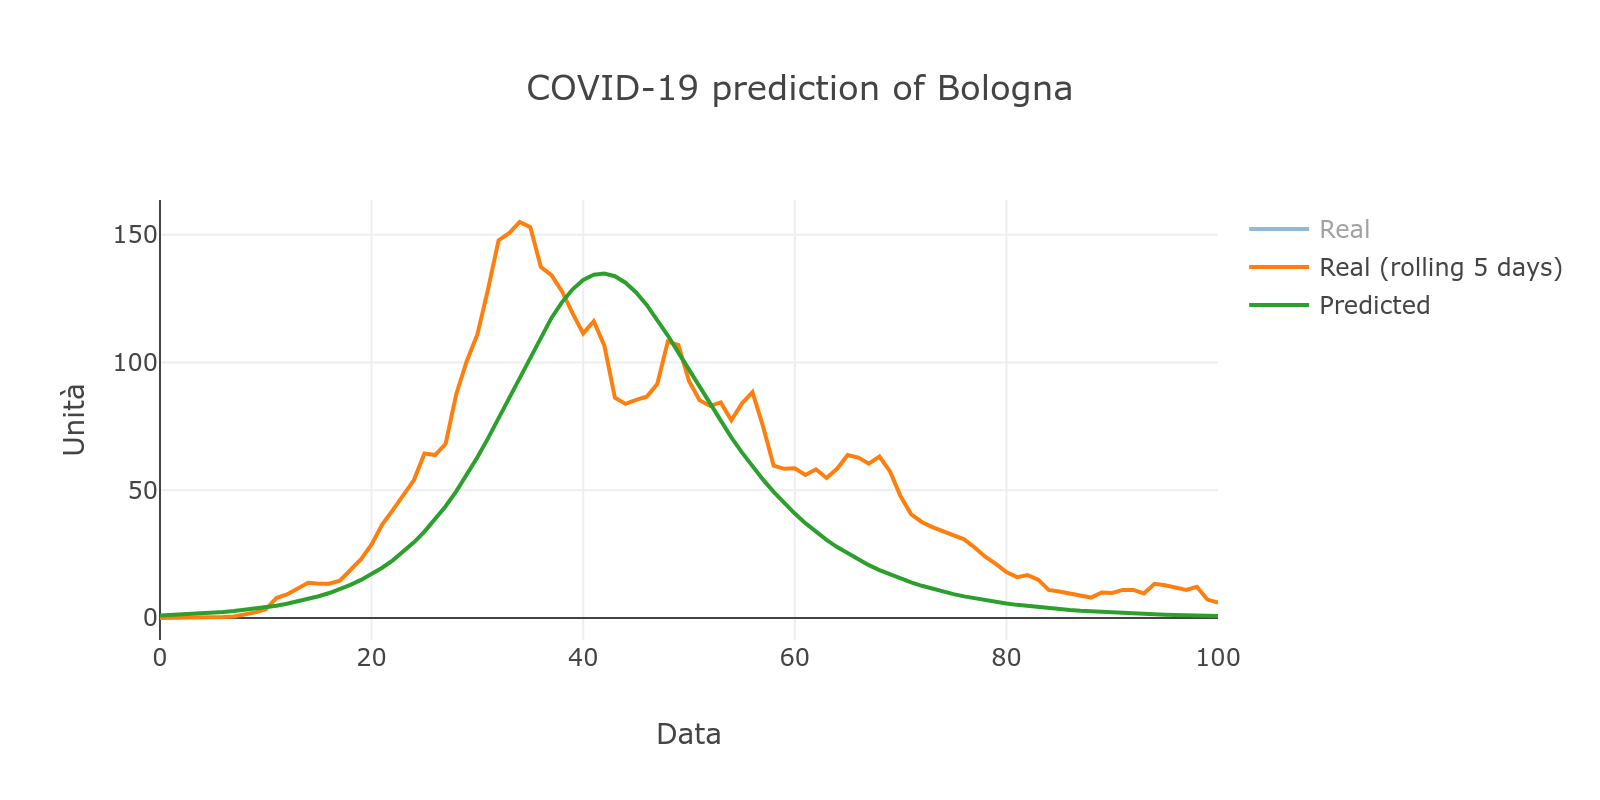

In [13]:
inter_dropdown_plot(options=result.Province.unique(), 
                    default_value='Bologna', 
                    dropdown_label='Province',
                    y=["real", "real_roll", "pred"],
                    legend_titles=names,
                    data=result,
                    group_column='Province',
                    x='t',
                    title='COVID-19 prediction of ',
                    xtitle='Data',
                    ytitle='Unità',
                    output_image=True,
                    traces_visibility=['legendonly',True,True])

In [14]:
mapping['Deaths'] = 4

In [15]:
def Model(days, N, R_0_start, k, x0, R_0_end):

    def beta(t):
        return logistic_R0(t, R_0_start, k, x0, R_0_end) * gamma

    y0 = N-1.0, 1.0, 0.0, 0.0,
    times = range(0, days)

    alpha = 0.05
    rho= 1/9
    gamma=1/7

    sirsol = odeint(sird_calc, y0, times, args=(N, gamma, alpha, rho, beta))

    S, I, R, D = sirsol.T
    R0_over_time = [beta(i)/gamma for i in range(len(times))]

    return times, S, I, R, D, R0_over_time

In [16]:
def fitter(x, R_0_start, k, x0, R_0_end):
    ret = Model(days, N, R_0_start, k, x0, R_0_end)
    return ret[mapping[compart]][x] # 2 for I, 4 for D

In [17]:
def get_model(province, compart, query='20200603 > Date', data_df=covidpro_df, pop_df=pop_prov_df):
    data = data_df[data_df.Province == province].query(query)[compart]
    if compart in ['New_cases', 'Deaths']:
        data = data.rolling(window=5).mean().fillna(0)
    
    N = pop_df.loc[(pop_df.Territorio == province) & (pop_df.Eta == "Total")]['Value'].values[0]

    # Day at which the curve starts to increase
    outbreak_shift = 20

    # {parameter: (initial guess, min value, max value)}
    params_init_min_max = {
        "R_0_start": (3.0, 1.0, 6),
        "k": (0.3, 0.01, 5.0),
        "x0": (20, 0, 100),
        "R_0_end": (0.9, 0.1, 3.5)
    }

    days = outbreak_shift + len(data)

    if outbreak_shift >= 0:
        y_data = np.concatenate((np.zeros(outbreak_shift), data))
    else:
        y_data = y_data[-outbreak_shift:]

    # [0, 1, ..., days]
    x_data = np.linspace(0, days-1, days, dtype=int)

    mod = lmfit.Model(fitter)

    for kwarg, (init, mini, maxi) in params_init_min_max.items():
        mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

    params = mod.make_params()

    return mod, params, y_data, x_data, days, N

In [18]:
province = 'Firenze'
compart = 'New_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart)

In [19]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [20]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 193
    # data points      = 120
    # variables        = 4
    chi-square         = 8605.34435
    reduced chi-square = 74.1840030
    Akaike info crit   = 520.717638
    Bayesian info crit = 531.867605
[[Variables]]
    R_0_start:  1.54263703 +/- 0.00409525 (0.27%) (init = 3)
    k:          4.99999903 +/- 23.6756768 (473.51%) (init = 0.3)
    x0:         59.8323445 +/- 0.39510017 (0.66%) (init = 20)
    R_0_end:    0.65141658 +/- 0.01832360 (2.81%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0) = -0.684
    C(x0, R_0_end)   = -0.529
    C(k, R_0_end)    =  0.369
    C(R_0_start, k)  = -0.176
    C(k, x0)         = -0.115


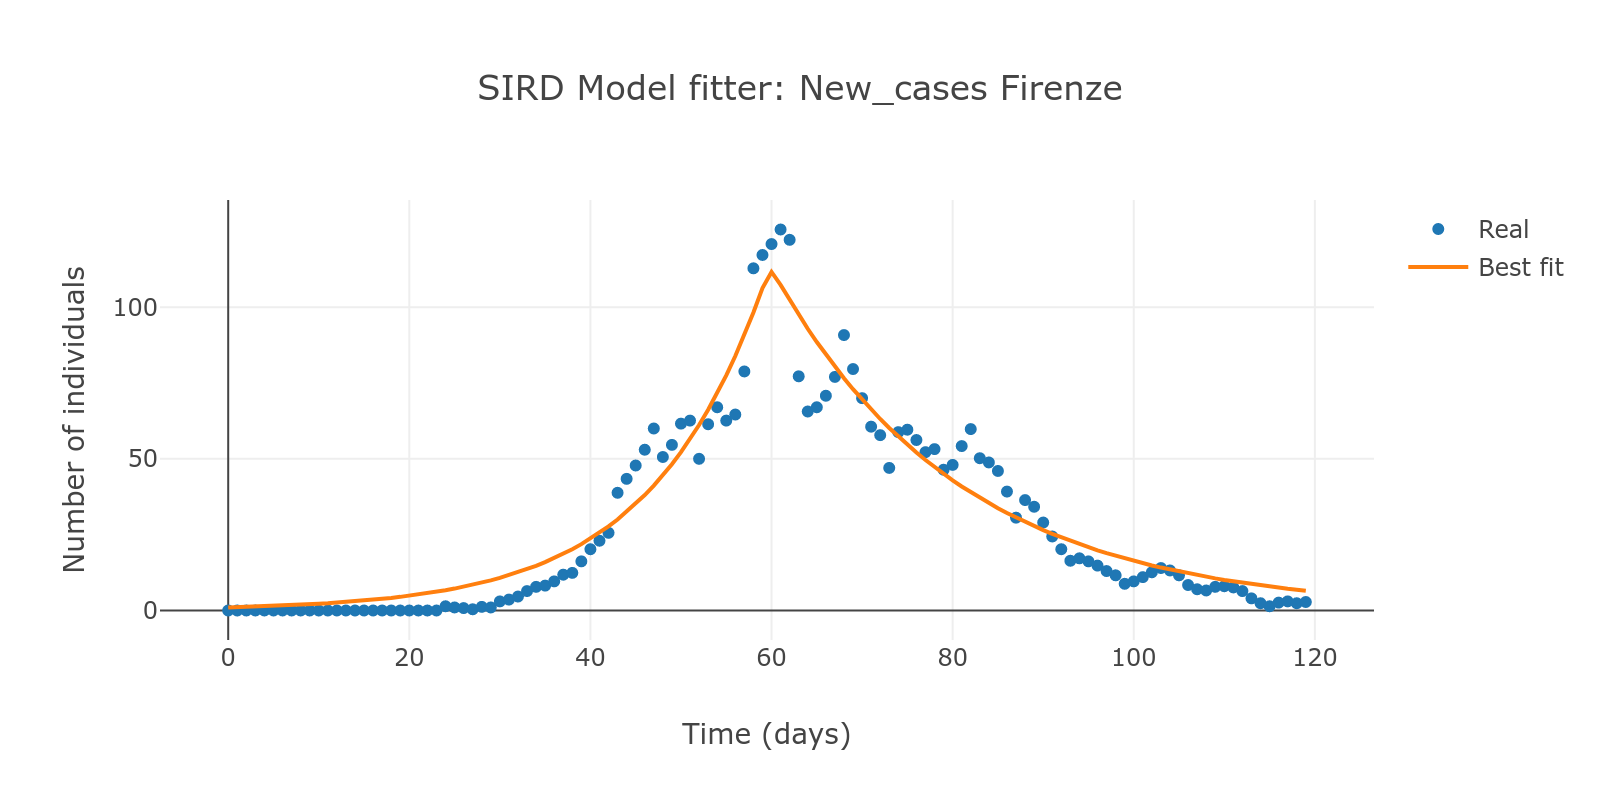

In [21]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [22]:
result.best_values

{'R_0_start': 1.5426370340726383,
 'k': 4.999999027719148,
 'x0': 59.832344453657306,
 'R_0_end': 0.6514165812320167}

In [23]:
province = 'Firenze'
compart = 'Curr_pos_cases'

mod, params, y_data, x_data, days, N = get_model(province, compart)

In [24]:
result = mod.fit(y_data, params, method="leastsq", x=x_data)

In [25]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 122
    # data points      = 120
    # variables        = 4
    chi-square         = 190498.384
    reduced chi-square = 1642.22745
    Akaike info crit   = 892.388870
    Bayesian info crit = 903.538837
[[Variables]]
    R_0_start:  1.96442235 +/- 0.00799240 (0.41%) (init = 3)
    k:          0.11107726 +/- 0.00370475 (3.34%) (init = 0.3)
    x0:         57.1922041 +/- 0.42139861 (0.74%) (init = 20)
    R_0_end:    1.02786142 +/- 0.00207262 (0.20%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(R_0_start, x0)      = -0.981
    C(R_0_start, k)       = -0.936
    C(k, x0)              =  0.861
    C(k, R_0_end)         =  0.810
    C(R_0_start, R_0_end) = -0.631
    C(x0, R_0_end)        =  0.470


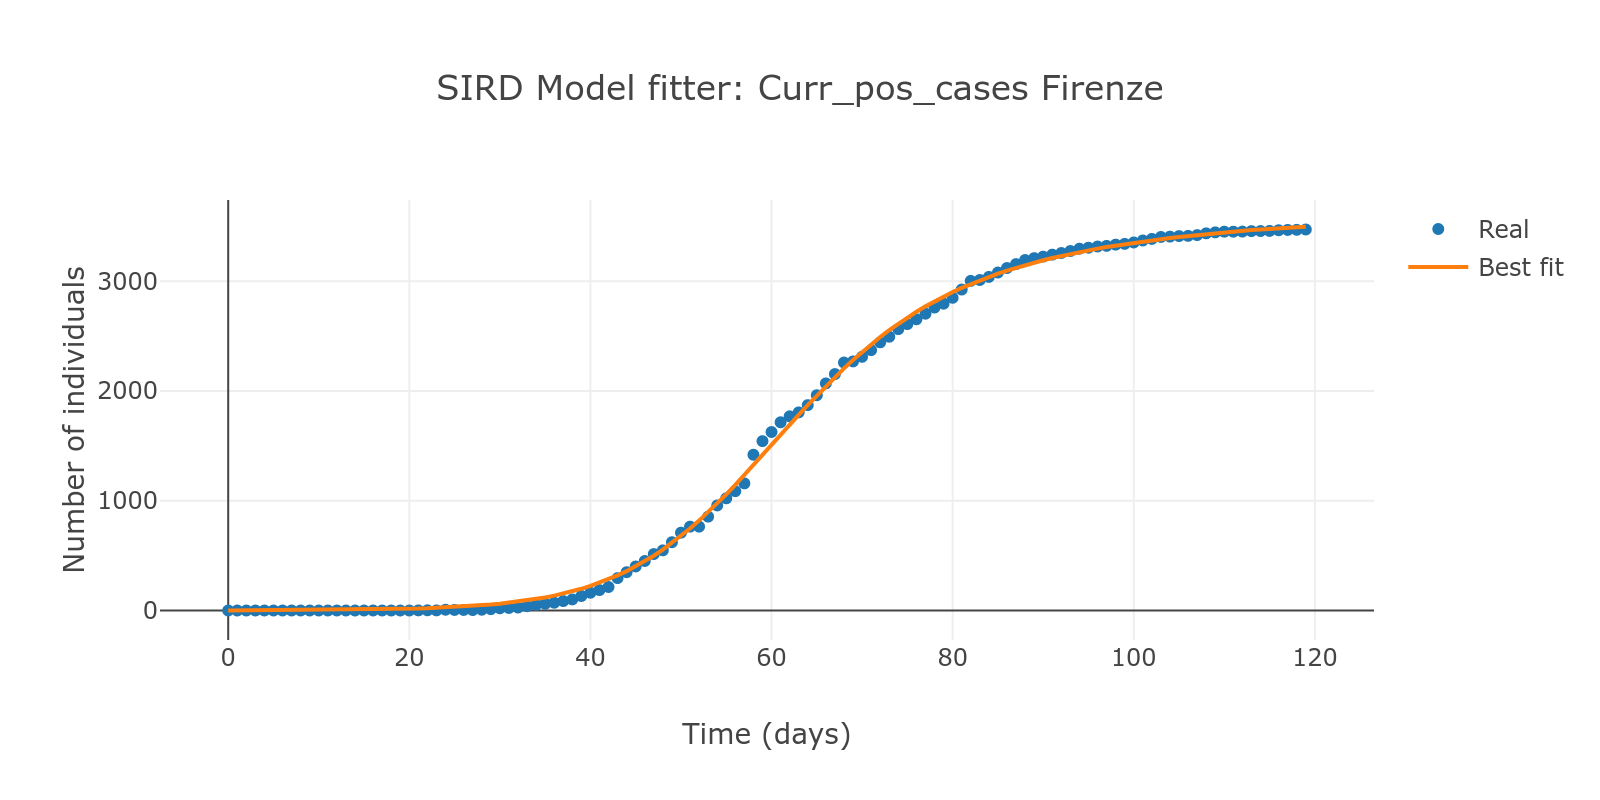

In [26]:
general_plot(t=x_data,
             title='Model fitter: ' + compart + ' ' + province,
             data=[result.data, result.best_fit], 
             names=['Real', 'Best fit'],
             modes=['markers', 'lines'],
             blend_legend=False,
             output_image=True)

In [27]:
result.best_values

{'R_0_start': 1.9644223517994095,
 'k': 0.1110772564470416,
 'x0': 57.192204076935504,
 'R_0_end': 1.0278614225286997}

In [ ]:
R_0_start, k, x0, R_0_end = result.best_values.values()